In [5]:
!where python

/bin/bash: line 1: where: command not found


# Load libraries

In [3]:
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

import pandas as pd
import requests
from io import BytesIO
import matplotlib.pyplot as plt
from glob import glob
import os
from copy import deepcopy

import numpy as np
import cv2
from PIL import Image
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras import optimizers
# from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
import os
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
from skimage.metrics import structural_similarity as ssim

import torch
from torch.utils.data import DataLoader, Dataset
# import albumentations as A
# from albumentations.pytorch import ToTensorV2
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import v2
from torchvision import transforms
from sklearn.model_selection import train_test_split

import tensorflow as tf


In [7]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [8]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


# Define helper functions/classes

In [1]:
## convert RGB to the personal LAB (LAB2)
# the input R,G,B,  must be 1D from 0 to 255
# the outputs are 1D  L [0 1], a [-1 1] b [-1 1]
def RGB2LAB2(R0, G0, B0):

    R=R0/255
    G=G0/255
    B=B0/255

    # Y=0.3*R + 0.59*G + 0.11*B
    # X=0.45*R + 0.35*G + 0.2*B
    # Z=0.01*R + 0.09*G + 0.9*B

    Y=0.299*R + 0.587*G + 0.114*B
    X=0.449*R + 0.353*G + 0.198*B
    Z=0.012*R + 0.089*G + 0.899*B

    # X - Y = 0.150*R - 0.234*G + 0.084*B  = a0
    # Y - Z = 0.287*R + 0.498*G - 0.785*B  = b0

    L = Y
    a = (X - Y)/0.234
    b = (Y - Z)/0.785

    return L, a, b

## convert the personal LAB (LAB2)to the RGB
# the input L,a,b,  must be 1D L [0 1], a [-1 1] b [-1 1]
# the outputs are 1D  R g B [0 255]
def LAB22RGB(L, a, b):

    a11 = 0.299
    a12 = 0.587
    a13 = 0.114
    a21 = (0.15/0.234)
    a22 = (-0.234/0.234)
    a23 = (0.084/0.234)
    a31 = (0.287/0.785)
    a32 = (0.498/0.785)
    a33 = (-0.785/0.785)

    aa=np.array([[a11, a12, a13], [a21, a22, a23], [a31, a32, a33]])
    C0=np.zeros((L.shape[0],3))
    C0[:,0]=L[:,0]
    C0[:,1]=a[:,0]
    C0[:,2]=b[:,0]
    C = np.transpose(C0)
    # C = np.array([L, a, b])
    # print(C.shape)
    # print(L.shape)
    # print(a.shape)
    # print(b.shape)
    # print(aa.shape)

    X = np.linalg.inv(aa).dot(C)
    X1D=np.reshape(X,(X.shape[0]*X.shape[1],1))
    p0=np.where(X1D<0)
    X1D[p0[0]]=0
    p1=np.where(X1D>1)
    X1D[p1[0]]=1
    Xr=np.reshape(X1D,(X.shape[0],X.shape[1]))

    Rr = Xr[0][:]
    Gr = Xr[1][:]
    Br = Xr[2][:]

    R = np.uint(np.round(Rr*255))
    G = np.uint(np.round(Gr*255))
    B = np.uint(np.round(Br*255))
    # p0=np.where(L<0.02)
    # R[p0[0]]=0
    # G[p0[0]]=0
    # B[p0[0]]=0
    # p1=np.where(L>0.98)
    # R[p1[0]]=255
    # G[p1[0]]=255
    # B[p1[0]]=255
    return R, G, B

# def convert_to_feed_model_func(RGB_image):

#     sz0=RGB_image.shape[0]
#     sz1=RGB_image.shape[1]

#     train_imgs=np.zeros((sz0,sz1,2))
#     train_input=np.zeros((sz0,sz1,1))

#     ab=np.zeros((sz0,sz1,2))
#     R1 = np.reshape(RGB_image[:,:,0],(sz0*sz1,1))
#     G1 = np.reshape(RGB_image[:,:,1],(sz0*sz1,1))
#     B1 = np.reshape(RGB_image[:,:,2],(sz0*sz1,1))
#     L, A, B = RGB2LAB2(R1,G1,B1)
#     A = np.reshape(A,(sz0,sz1))
#     B = np.reshape(B,(sz0,sz1))
#     ab[:,:,0] = A
#     ab[:,:,1] = B
#     train_input[:,:,:] =  np.reshape(L,(1,sz0,sz1,1))
#     train_imgs[:,:,:] = np.reshape(ab,(1,sz0,sz1,2))

#     return (train_input, train_imgs)


In [10]:

####### Metrics #######


def psnr(img1, img2):
    mse = np.mean( (img1.astype("float") - img2.astype("float")) ** 2 )
    # print(mse)
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

def mse(imageA, imageB, bands):
	# the 'Mean Squared Error' between the two images is the
	# sum of the squared difference between the two images;
	# NOTE: the two images must have the same dimension
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1] * bands)

	# return the MSE, the lower the error, the more "similar"
	# the two images are
	return err

def mae(imageA, imageB, bands):
 	# the 'Mean Squared Error' between the two images is the
 	# sum of the squared difference between the two images;
 	# NOTE: the two images must have the same dimension
 	err = np.sum(np.abs((imageA.astype("float") - imageB.astype("float"))))
 	err /= float(imageA.shape[0] * imageA.shape[1] * bands)
 	return err

def rmse(imageA, imageB, bands):
	# the 'Mean Squared Error' between the two images is the
	# sum of the squared difference between the two images;
	# NOTE: the two images must have the same dimension
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1] * bands)
	err = np.sqrt(err)
	return err

# Define transforms


In [11]:
class convert_RGB_to_feed_model(torch.nn.Module):
    def forward(self, img):
        img = np.asanyarray(img)
        sz0=img.shape[0]
        sz1=img.shape[1]

        train_imgs=np.zeros((sz0,sz1,2))
        train_input=np.zeros((sz0,sz1,1))

        ab=np.zeros((sz0,sz1,2))
        R1 = np.reshape(img[:,:,0],(sz0*sz1,1))
        G1 = np.reshape(img[:,:,1],(sz0*sz1,1))
        B1 = np.reshape(img[:,:,2],(sz0*sz1,1))
        L, A, B = RGB2LAB2(R1,G1,B1)
        A = np.reshape(A,(sz0,sz1))
        B = np.reshape(B,(sz0,sz1))
        ab[:,:,0] = A
        ab[:,:,1] = B
        train_input[:,:,:] =  np.reshape(L,(1,sz0,sz1,1))
        train_imgs[:,:,:] = np.reshape(ab,(1,sz0,sz1,2))
        return (train_input, train_imgs)

In [12]:
# NOTE: need to crate a transform class to revert from model to RGB, so the oposite from the class convert_RGB_to_feed_model
class convert_from_LAB_to_RGB(torch.nn.Module):
    def forward(self, img_raw):
        image, _ = img_raw
        print(image.shape)
        # sz0 = image.shape[0]
        # sz1 = image.shape[1]
        # sz2 = image.shape[2]
        # LAB_img = np.reshape(LAB_img,(sz0*sz1,bands))
        # Ar = LAB_img[:,0:1]
        # Br = LAB_img[:,1:2]

        # Rr, Gr, Br = LAB22RGB(L,Ar,Br)
        # Rr = np.reshape(Rr,(sz0,sz1))
        # Gr = np.reshape(Gr,(sz0,sz1))
        # Br = np.reshape(Br,(sz0,sz1))
        # predicted255=np.uint8(np.zeros((sz0,sz1,3)))
        # predicted255[:,:,0] = Rr
        # predicted255[:,:,1] = Gr
        # predicted255[:,:,2] = Br
        # return (predicted255)

In [13]:
img_new_dim = 512

train_transforms = transforms.Compose(
    [
        # transforms.Resize(size=(img_new_dim, img_new_dim)),
        convert_RGB_to_feed_model()
        # transforms.Lambda(convert_to_feed_model),
        # v2.RandomHorizontalFlip(p=1),
        # v2.Normalize(mean=[0, 0, 0], std=[1, 1, 1])
    ]
)

# Download the raw data

The data was initially created using the scripts `retrieve_data.ipynb` and stored in a private server for later (re)use.

NOTE: the following are links stored in a private server, jet publically available

In [14]:
# raw_data_csv_file_link = "https://perritos.myasustor.com:3853/portal/apis/fileExplorer/download.cgi?act=download&link=EKxhA76k9&link_session_id=cDXOk9eeE9Es2a1JU1IOvA00&total=1&browser=firefox&mod_cntype=0&path=%2FRuben%2Fdatasets%2Ffetched_raw_imgs_via_api&file=metadata.csv"
raw_data_csv_file_link = "https://perritos.myasustor.com:1985/metadata.csv"
# only working locally
# raw_data_csv_file_link =
# "/Volumes/Ruben/datasets/fetched_raw_imgs_via_api/metadata.csv"

metadata_raw_df = pd.read_csv(raw_data_csv_file_link, index_col=0)
metadata_raw_df

,img_id,img_name,latitude,longitude,zoom_level,class,link
0,0,3857_17_68545_45993,47.201780,8.264822,17,61,https://wmts0.geo.admin.ch/1.0.0/ch.swisstopo....
1,1,3857_16_34290_23041,47.032835,8.360899,16,61,https://wmts0.geo.admin.ch/1.0.0/ch.swisstopo....
2,2,3857_16_34497_22906,47.536282,9.500052,16,61,https://wmts0.geo.admin.ch/1.0.0/ch.swisstopo....
3,3,3857_17_67996_46176,46.860006,6.759327,17,61,https://wmts0.geo.admin.ch/1.0.0/ch.swisstopo....
4,4,3857_17_68797_46090,47.021068,8.959244,17,61,https://wmts0.geo.admin.ch/1.0.0/ch.swisstopo....
...,...,...,...,...,...,...,...
3595,3595,3857_17_68680_46248,46.723525,8.635565,17,66,https://wmts0.geo.admin.ch/1.0.0/ch.swisstopo....
3596,3596,3857_16_34412_23109,46.778972,9.030993,16,66,https://wmts0.geo.admin.ch/1.0.0/ch.swisstopo....
3597,3597,3857_17_68885_46306,46.613634,9.199782,17,66,https://wmts0.geo.admin.ch/1.0.0/ch.swisstopo....
3598,3598,3857_16_34489_23157,46.598598,9.455155,16,66,https://wmts0.geo.admin.ch/1.0.0/ch.swisstopo....


In [15]:
metadata_raw_df["class"].iloc[0]

61

In [16]:
metadata_raw_df.shape

(3600, 7)

# Create Train, Valid and Test datasets

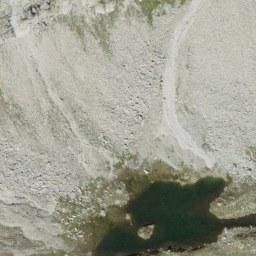

In [17]:
# This is an example how to retrieve a sample image
url = "https://perritos.myasustor.com:1985/data/img_id_10.jpg"
# url = "https://192.168.1.144:1985/data/img_id_0.jpg"
response = requests.get(url)
img_test = Image.open(BytesIO(response.content))
img_test

In [18]:
transformed_img = train_transforms(img_test)
transformed_img

(array([[[0.64623137],
         [0.72074118],
         [0.74427059],
         ...,
         [0.68269804],
         [0.71407059],
         [0.77681569]],
 
        [[0.61093725],
         [0.70897647],
         [0.76387843],
         ...,
         [0.69838431],
         [0.70622745],
         [0.73367843]],
 
        [[0.68293333],
         [0.72607059],
         [0.70646275],
         ...,
         [0.72191373],
         [0.71407059],
         [0.69054118]],
 
        ...,
 
        [[0.56183922],
         [0.54105882],
         [0.5265451 ],
         ...,
         [0.56870196],
         [0.59615294],
         [0.53732941]],
 
        [[0.53628627],
         [0.52172941],
         [0.51275686],
         ...,
         [0.49508627],
         [0.49900784],
         [0.48332157]],
 
        [[0.52844314],
         [0.51275686],
         [0.51667843],
         ...,
         [0.53038039],
         [0.53038039],
         [0.54606667]]]),
 array([[[-0.01377577,  0.0299388 ],
         [-0.01377

We use the column `image_id` from the metadata as index of the images and then we perform standard shufling and splitting.

The final ratio for the train, validation and test dastasets are: 75, 15 and 10 % respectively

In [19]:
dataX, dataY = metadata_raw_df["img_id"].to_list(), metadata_raw_df["class"] .to_list()

rand_state = 9898
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10



# train is now 75% of the entire data set
x_train, x_test, y_train, y_test = train_test_split(dataX, dataY, test_size=1 - train_ratio, stratify = dataY, random_state=rand_state)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), stratify=y_test, random_state=rand_state)

print(f"the size fo the train dataset is: {len(x_train)}.\nthe size fo the validation dataset is: {len(x_val)}.\nthe size fo the test dataset is: {len(x_test)}.")

the size fo the train dataset is: 2700.
the size fo the validation dataset is: 540.
the size fo the test dataset is: 360.


# Create a Dataset class

In [20]:
# the idea was borrowed from here: https://towardsdatascience.com/custom-dataset-in-pytorch-part-1-images-2df3152895

class Swisstopodataset(Dataset):
    def __init__(self, img_indx, metadata_file, transform = False):
        self.img_indx = img_indx
        self.transform = transform
        self.metadata_file = metadata_file

    def __len__(self):
        return len(self.img_indx)

    def __getitem__(self, idx):
        # img_filepath  = self.img_indx[idx]
        response = requests.get(f"https://perritos.myasustor.com:1985/data/img_id_{self.img_indx[idx]}.jpg")
        image = Image.open(BytesIO(response.content))
        # image = cv2.imread(img_filepath)
        # image = Image.fromarray(image)

        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # define here a label if existing
        label = self.metadata_file["class"].iloc[idx]

        if self.transform is not None:
            image = self.transform(image)

        return image, label


In [21]:
train_dataset = Swisstopodataset(x_train, metadata_file=metadata_raw_df, transform=train_transforms)
valid_dataset= Swisstopodataset(x_val, metadata_file=metadata_raw_df, transform=train_transforms)
test_dataset= Swisstopodataset(x_test, metadata_file=metadata_raw_df, transform=train_transforms)
example_indx = 49

print(f"The shape of tensor for {example_indx +1 }th image in the train dataset of: \nchannel L is:{train_dataset[example_indx][0][0].shape}\nchannel AB is:{train_dataset[example_indx][0][1].shape}\nlabel: {train_dataset[example_indx][1]}")
print(f"\n\nThe shape of tensor for {example_indx +1 }th image in the validate dataset of: \nchannel L is:{train_dataset[example_indx][0][0].shape}\nchannel AB is:{train_dataset[example_indx][0][1].shape}\nlabel: {train_dataset[example_indx][1]}")
# print(f"The shape of tensor for 50th image in train dataset of channel L is :{train_dataset[49][0].shape}\nand of channel AB is :{train_dataset[49][1].shape}")


The shape of tensor for 50th image in the train dataset of: 
channel L is:(256, 256, 1)
channel AB is:(256, 256, 2)
label: 61


The shape of tensor for 50th image in the validate dataset of: 
channel L is:(256, 256, 1)
channel AB is:(256, 256, 2)
label: 61


In [22]:
valid_dataset[1]

((array([[[0.53572549],
          [0.622     ],
          [0.59847059],
          ...,
          [0.56054902],
          [0.58407843],
          [0.59192157]],
  
         [[0.56709804],
          [0.64552941],
          [0.61807843],
          ...,
          [0.59584314],
          [0.61152941],
          [0.63113725]],
  
         [[0.4847451 ],
          [0.48866667],
          [0.47298039],
          ...,
          [0.6224    ],
          [0.62632157],
          [0.65769412]],
  
         ...,
  
         [[0.55281176],
          [0.47045882],
          [0.47830196],
          ...,
          [0.5692    ],
          [0.61048235],
          [0.64577647]],
  
         [[0.50575294],
          [0.49006667],
          [0.55281176],
          ...,
          [0.52214118],
          [0.51244314],
          [0.5673451 ]],
  
         [[0.49398824],
          [0.53320392],
          [0.50575294],
          ...,
          [0.66723922],
          [0.59871765],
          [0.60263922]]]),
  arra

# Visualize the datasets (images)

In [23]:
def visualize_dataset(dataset, samples = 10, cols = 5, random_img = False):
    dataset = deepcopy(dataset)
    # revert transforms if exixting
    # dataset.transform = transforms.Compose([t for t in dataset.transform if not isinstance(t, convert_RGB_to_feed_model)])
    dataset.transform = transforms.Compose([t for t in test_dataset.transform.transforms if not t.__class__.__name__ == "convert_RGB_to_feed_model"])
    # if "convert_RGB_to_feed_model" in test_dataset.transform.transforms:
    #     dataset.transform = transforms.Compose()

    rows = samples // cols

    figure, ax = plt.subplots(nrows= rows, ncols = cols, figsize = (12, 8))
    for i in range(samples):
        if random_img:
            idx = np.random.randint(1, len(dataset))
        image, label = dataset[idx][0], dataset[idx][1]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
        ax.ravel()[i].set_title(f"Img label: {label}")
    plt.tight_layout(pad=1)
    plt.show()

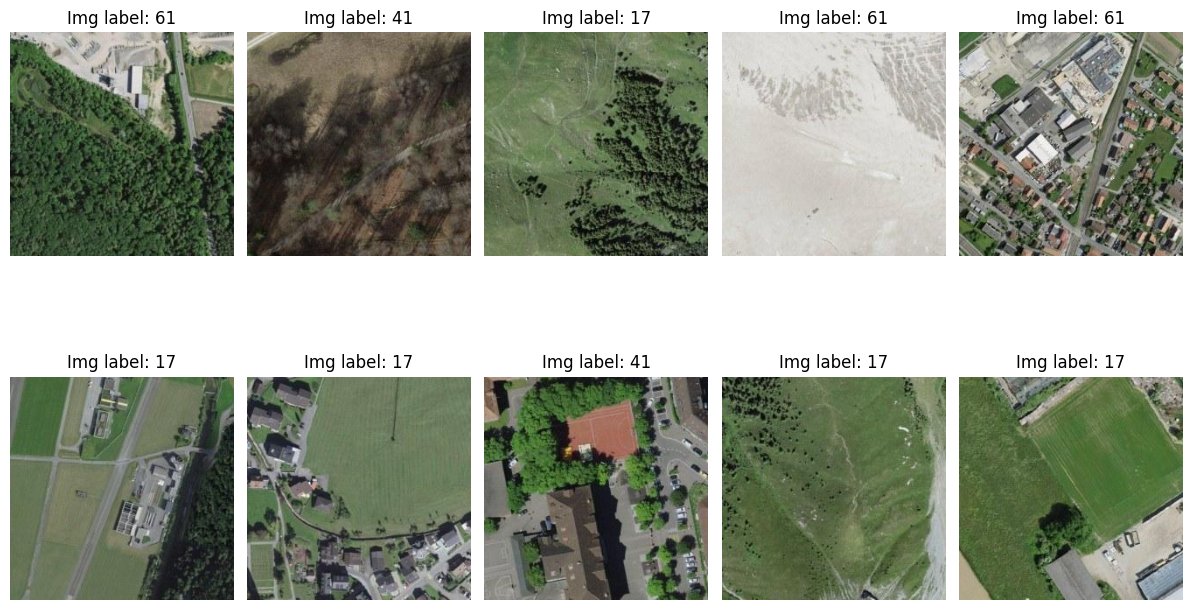

In [24]:
visualize_dataset(test_dataset, random_img= True)

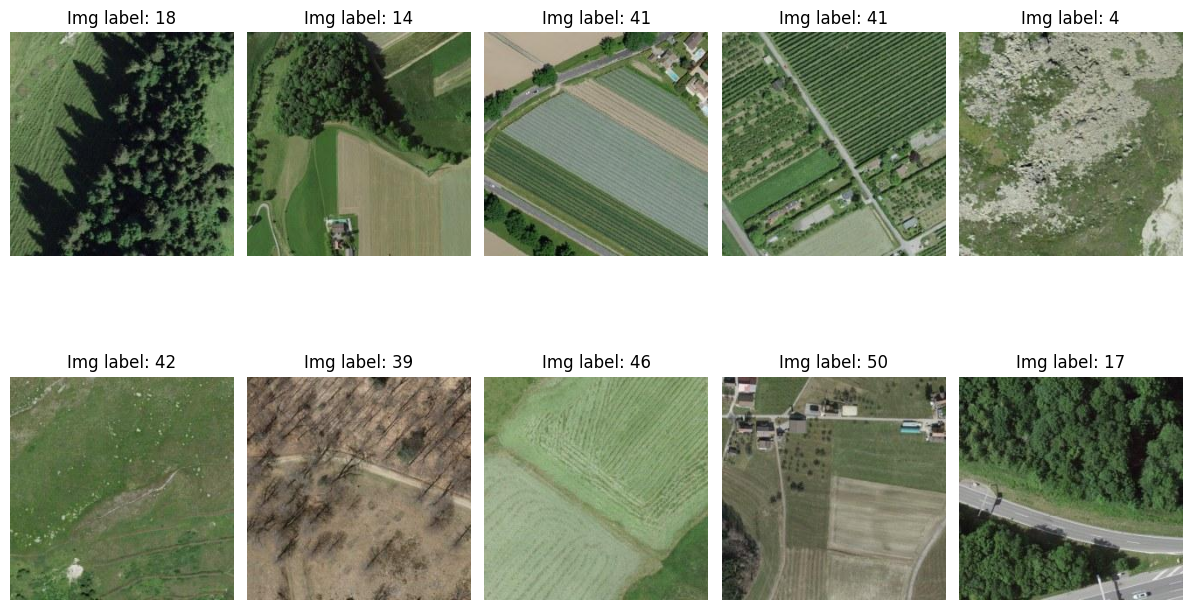

In [25]:
visualize_dataset(valid_dataset, random_img= True)

# Create Tensorflow Datasets

In [26]:
class Swisstopodataset(Dataset):
    def __init__(self, img_indx, metadata_file, transform=False):
        self.img_indx = img_indx
        self.transform = transform
        self.metadata_file = metadata_file

    def __len__(self):
        return len(self.img_indx)

    def __getitem__(self, idx):
        response = requests.get(f"https://perritos.myasustor.com:1985/data/img_id_{self.img_indx[idx]}.jpg")
        image = Image.open(BytesIO(response.content))

        if self.transform is not None:
            image = self.transform(image)

        return image


In [27]:
train_dataset = Swisstopodataset(x_train, metadata_file=metadata_raw_df, transform=train_transforms)
valid_dataset = Swisstopodataset(x_val, metadata_file=metadata_raw_df, transform=train_transforms)
test_dataset = Swisstopodataset(x_test, metadata_file=metadata_raw_df, transform=train_transforms)

print(train_dataset[0][0].shape)
print(train_dataset[0][1].shape)



(256, 256, 1)
(256, 256, 2)


In [28]:
train_samples = len(train_dataset)
valid_samples = len(valid_dataset)
test_samples = len(test_dataset)

In [29]:
# Print the number of samples
print("Number of samples in the training dataset:", train_samples)
print("Number of samples in the validation dataset:", valid_samples)
print("Number of samples in the test dataset:", test_samples)

Number of samples in the training dataset: 2700
Number of samples in the validation dataset: 540
Number of samples in the test dataset: 360


In [31]:
def create_tf_dataset(dataset, desc):
    L_channel_data = []
    AB_channel_data = []
    total_samples = len(dataset)
    with tqdm(total=total_samples, desc=desc) as pbar:
        for sample in dataset:
            # Assuming sample is a tuple of (L_channel, AB_channel)
            L_channel, AB_channel = sample  # Unpack the tuple

            # Append to the lists
            L_channel_data.append(tf.convert_to_tensor(L_channel, dtype=tf.float32))
            AB_channel_data.append(tf.convert_to_tensor(AB_channel, dtype=tf.float32))
            pbar.update(1)

    # Create a TensorFlow dataset from the lists of tensors
    return tf.data.Dataset.from_tensor_slices((L_channel_data, AB_channel_data))


In [32]:
tf_train_dataset = create_tf_dataset(train_dataset, 'Creating Train Dataset')
tf_valid_dataset = create_tf_dataset(valid_dataset, 'Creating Validation Dataset')
tf_test_dataset = create_tf_dataset(test_dataset, 'Creating Test Dataset')

Creating Test Dataset: 100%|██████████| 360/360 [04:13<00:00,  1.42it/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

save_path = '/content/drive/MyDrive/Tensordata'

# Save the datasets
tf.data.Dataset.save(tf_train_dataset, f'{save_path}/train_dataset')
tf.data.Dataset.save(tf_valid_dataset, f'{save_path}/valid_dataset')
tf.data.Dataset.save(tf_test_dataset, f'{save_path}/test_dataset')

Mounted at /content/drive


In [33]:
import tensorflow as tf
import os
from tqdm import tqdm

# Serialize the dataset and save to TFRecord files
def serialize_example(L_channel, AB_channels):
    feature = {
        'L_channel': tf.train.Feature(float_list=tf.train.FloatList(value=L_channel.numpy().flatten())),
        'AB_channels': tf.train.Feature(float_list=tf.train.FloatList(value=AB_channels.numpy().flatten()))
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

def write_tfrecord(dataset, file_path):
    writer = tf.io.TFRecordWriter(file_path)
    total_samples = len(dataset)
    with tqdm(total=total_samples, desc=f'Saving {os.path.basename(file_path)}') as pbar:
        for L, AB in dataset:
            example = serialize_example(L, AB)
            writer.write(example)
            pbar.update(1)
    writer.close()

# Save path
save_path = '/content/drive/MyDrive/Tensordata'

# Save the datasets
write_tfrecord(tf_train_dataset, os.path.join(save_path, 'train_dataset.tfrecord'))
write_tfrecord(tf_valid_dataset, os.path.join(save_path, 'valid_dataset.tfrecord'))
write_tfrecord(tf_test_dataset, os.path.join(save_path, 'test_dataset.tfrecord'))


Saving test_dataset.tfrecord: 100%|██████████| 360/360 [00:41<00:00,  8.73it/s]


# Load presaved Tensor Datasets

In [4]:
from google.colab import drive
drive.mount('/content/drive')

save_path = '/content/drive/MyDrive/Tensordata'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Define the element spec
element_spec = (
    tf.TensorSpec(shape=(256, 256, 1), dtype=tf.float32),
    tf.TensorSpec(shape=(256, 256, 2), dtype=tf.float32)
)

# Function to parse the examples
def parse_tfrecord_fn(example_proto):
    feature_description = {
        'L_channel': tf.io.FixedLenFeature([256*256*1], tf.float32),
        'AB_channels': tf.io.FixedLenFeature([256*256*2], tf.float32)
    }
    example = tf.io.parse_single_example(example_proto, feature_description)
    L_channel = tf.reshape(example['L_channel'], [256, 256, 1])
    AB_channels = tf.reshape(example['AB_channels'], [256, 256, 2])
    return L_channel, AB_channels

save_path = '/content/drive/MyDrive/Tensordata'

# Load the datasets without element_spec in TFRecordDataset
train_dataset = tf.data.TFRecordDataset(f'{save_path}/train_dataset.tfrecord')
train_dataset = train_dataset.map(parse_tfrecord_fn)

valid_dataset = tf.data.TFRecordDataset(f'{save_path}/valid_dataset.tfrecord')
valid_dataset = valid_dataset.map(parse_tfrecord_fn)

test_dataset = tf.data.TFRecordDataset(f'{save_path}/test_dataset.tfrecord')
test_dataset = test_dataset.map(parse_tfrecord_fn)

In [6]:
def count_samples(dataset):
    return dataset.reduce(0, lambda x, _: x + 1).numpy()

# Assuming train_dataset, valid_dataset, and test_dataset are tf.data.Dataset objects
train_samples = count_samples(train_dataset)
valid_samples = count_samples(valid_dataset)
test_samples = count_samples(test_dataset)

print("Number of samples in the training dataset:", train_samples)
print("Number of samples in the validation dataset:", valid_samples)
print("Number of samples in the test dataset:", test_samples)

Number of samples in the training dataset: 2700
Number of samples in the validation dataset: 540
Number of samples in the test dataset: 360


In [7]:
# Print the first few elements of the datasets
for i, (L, AB) in enumerate(train_dataset.take(5)):
    print(f"Sample {i+1}: L shape={L.shape}, AB shape={AB.shape}")

for i, (L, AB) in enumerate(valid_dataset.take(5)):
    print(f"Sample {i+1}: L shape={L.shape}, AB shape={AB.shape}")

for i, (L, AB) in enumerate(test_dataset.take(5)):
    print(f"Sample {i+1}: L shape={L.shape}, AB shape={AB.shape}")


Sample 1: L shape=(256, 256, 1), AB shape=(256, 256, 2)
Sample 2: L shape=(256, 256, 1), AB shape=(256, 256, 2)
Sample 3: L shape=(256, 256, 1), AB shape=(256, 256, 2)
Sample 4: L shape=(256, 256, 1), AB shape=(256, 256, 2)
Sample 5: L shape=(256, 256, 1), AB shape=(256, 256, 2)
Sample 1: L shape=(256, 256, 1), AB shape=(256, 256, 2)
Sample 2: L shape=(256, 256, 1), AB shape=(256, 256, 2)
Sample 3: L shape=(256, 256, 1), AB shape=(256, 256, 2)
Sample 4: L shape=(256, 256, 1), AB shape=(256, 256, 2)
Sample 5: L shape=(256, 256, 1), AB shape=(256, 256, 2)
Sample 1: L shape=(256, 256, 1), AB shape=(256, 256, 2)
Sample 2: L shape=(256, 256, 1), AB shape=(256, 256, 2)
Sample 3: L shape=(256, 256, 1), AB shape=(256, 256, 2)
Sample 4: L shape=(256, 256, 1), AB shape=(256, 256, 2)
Sample 5: L shape=(256, 256, 1), AB shape=(256, 256, 2)


In [8]:
# Calculate steps per epoch
batch_size = 16
train_steps_per_epoch = train_samples // batch_size
valid_steps_per_epoch = valid_samples // batch_size
test_steps_per_epoch = test_samples // batch_size

# Shuffle, repeat, and batch the datasets
train_data = train_dataset.shuffle(buffer_size=train_samples).repeat().batch(batch_size)
valid_data = valid_dataset.shuffle(buffer_size=valid_samples).repeat().batch(batch_size)
test_data = test_dataset.batch(batch_size)


# Retrain the model

In [9]:
!pip install gdown
!gdown --id 19DaA9f1HIOW9PmUz11xKw65fCo3X7-Fw --output Hyper_U_Net.h5

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=19DaA9f1HIOW9PmUz11xKw65fCo3X7-Fw
From (redirected): https://drive.google.com/uc?id=19DaA9f1HIOW9PmUz11xKw65fCo3X7-Fw&confirm=t&uuid=76eae124-85a0-4c52-be58-28ee8cb9e720
To: /content/Hyper_U_Net.h5
100% 500M/500M [00:20<00:00, 24.9MB/s]


In [10]:
# Define the file path of the downloaded model
model_file_path = '/content/Hyper_U_Net.h5'

# Load the saved model
loaded_model = tf.keras.models.load_model(model_file_path)

# Freeze all layers except the last one
for layer in loaded_model.layers[:-1]:
    layer.trainable = False

# Function to count the number of parameters
def count_params(model, only_trainable=False):
    if only_trainable:
        return np.sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
    else:
        return np.sum([tf.keras.backend.count_params(w) for w in model.trainable_weights + model.non_trainable_weights])

# Get the number of trainable and non-trainable parameters
trainable_params = count_params(loaded_model, only_trainable=True)
total_params = count_params(loaded_model)

print(f"Trainable parameters: {trainable_params}")
print(f"Total parameters: {total_params}")

# Display model summary
loaded_model.summary()

Trainable parameters: 1154
Total parameters: 41615234
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 1)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, None, None, 64)       640       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, None, None, 64)       36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, None, None, 64)       0         ['conv2d_1[0][0]']            
 D)                                     

Only Head Unfrozen

In [20]:
# Training the model
epochs = 10
history = loaded_model.fit(train_data,
                           validation_data=valid_data,
                           epochs=epochs,
                           steps_per_epoch=train_steps_per_epoch,
                           validation_steps=valid_steps_per_epoch)


Epoch 1/10
168/168 [==============================] - 113s 613ms/step - loss: 0.0019 - accuracy: 0.8928 - val_loss: 0.0019 - val_accuracy: 0.8946
Epoch 2/10
168/168 [==============================] - 101s 602ms/step - loss: 0.0019 - accuracy: 0.8920 - val_loss: 0.0019 - val_accuracy: 0.8927
Epoch 3/10
168/168 [==============================] - 103s 616ms/step - loss: 0.0019 - accuracy: 0.8917 - val_loss: 0.0019 - val_accuracy: 0.8948
Epoch 4/10
168/168 [==============================] - 99s 592ms/step - loss: 0.0019 - accuracy: 0.8912 - val_loss: 0.0019 - val_accuracy: 0.8929
Epoch 5/10
168/168 [==============================] - 103s 615ms/step - loss: 0.0018 - accuracy: 0.8925 - val_loss: 0.0019 - val_accuracy: 0.8944
Epoch 6/10
168/168 [==============================] - 103s 616ms/step - loss: 0.0019 - accuracy: 0.8908 - val_loss: 0.0019 - val_accuracy: 0.8950
Epoch 7/10
168/168 [==============================] - 103s 616ms/step - loss: 0.0018 - accuracy: 0.8913 - val_loss: 0.0019 - 

In [21]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = loaded_model.evaluate(test_data, steps=test_steps_per_epoch)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')


22/22 [==============================] - 11s 473ms/step - loss: 0.0019 - accuracy: 0.9000
Test Loss: 0.0018571298569440842
Test Accuracy: 0.8999931812286377


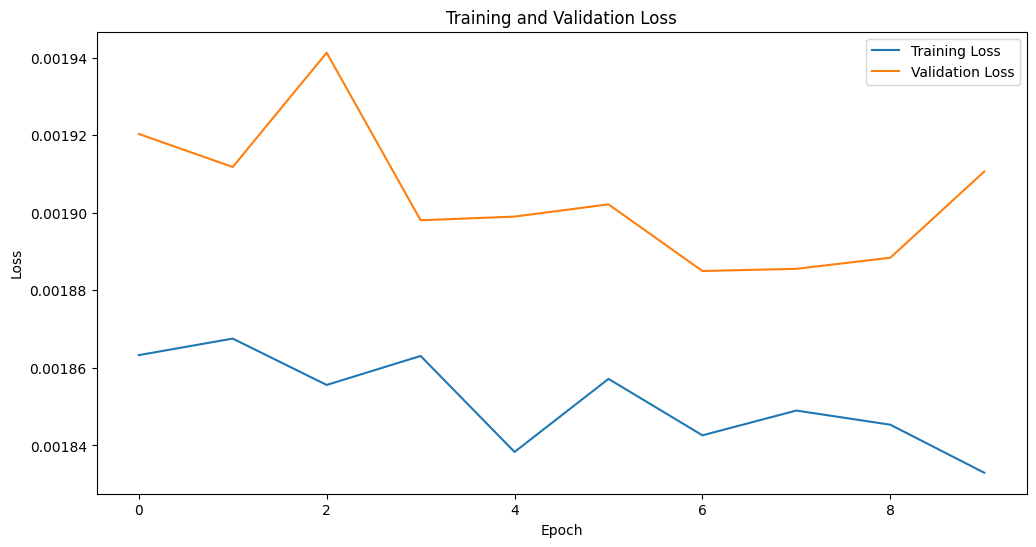

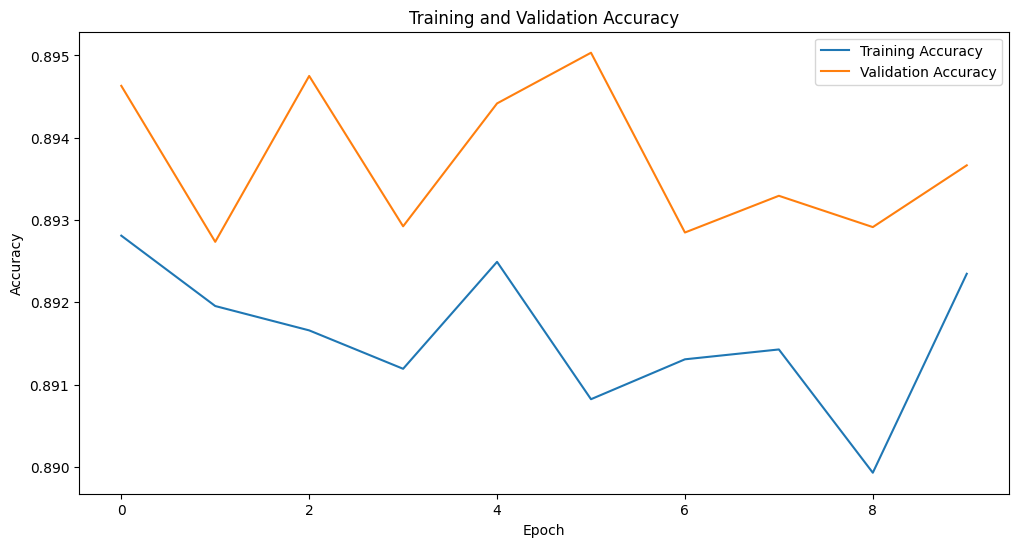

In [22]:
# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [23]:
# Save the trained model
model_save_path = '/content/drive/MyDrive/CAS Avanced Machine Learning/Luftbild_Colarization'
loaded_model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /content/drive/MyDrive/CAS Avanced Machine Learning/Luftbild_Colarization


In [13]:
# Load the saved model
loaded_model = tf.keras.models.load_model(model_file_path)

# Find the index of the last encoder layer
last_encoder_layer_index = loaded_model.layers.index(loaded_model.get_layer('max_pooling2d_4'))

# Freeze all layers up to the last encoder layer
for layer in loaded_model.layers[:last_encoder_layer_index + 1]:
    layer.trainable = False

# Compile the model after freezing the encoder layers
loaded_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [14]:
# Training the model
epochs = 10
history = loaded_model.fit(train_data,
                           validation_data=valid_data,
                           epochs=epochs,
                           steps_per_epoch=train_steps_per_epoch,
                           validation_steps=valid_steps_per_epoch)


Epoch 1/10
168/168 [==============================] - 308s 2s/step - loss: 0.0018 - accuracy: 0.8976 - val_loss: 0.0014 - val_accuracy: 0.9032
Epoch 2/10
168/168 [==============================] - 262s 2s/step - loss: 0.0013 - accuracy: 0.9065 - val_loss: 0.0014 - val_accuracy: 0.9062
Epoch 3/10
168/168 [==============================] - 266s 2s/step - loss: 0.0013 - accuracy: 0.9047 - val_loss: 0.0015 - val_accuracy: 0.9051
Epoch 4/10
168/168 [==============================] - 265s 2s/step - loss: 0.0012 - accuracy: 0.9065 - val_loss: 0.0013 - val_accuracy: 0.9129
Epoch 5/10
168/168 [==============================] - 265s 2s/step - loss: 0.0012 - accuracy: 0.9097 - val_loss: 0.0012 - val_accuracy: 0.9147
Epoch 6/10
168/168 [==============================] - 262s 2s/step - loss: 0.0011 - accuracy: 0.9098 - val_loss: 0.0012 - val_accuracy: 0.9137
Epoch 7/10
168/168 [==============================] - 262s 2s/step - loss: 0.0011 - accuracy: 0.9123 - val_loss: 0.0012 - val_accuracy: 0.9128

In [15]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = loaded_model.evaluate(test_data, steps=test_steps_per_epoch)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')


22/22 [==============================] - 11s 475ms/step - loss: 0.0011 - accuracy: 0.9146
Test Loss: 0.001121582230553031
Test Accuracy: 0.9145596027374268


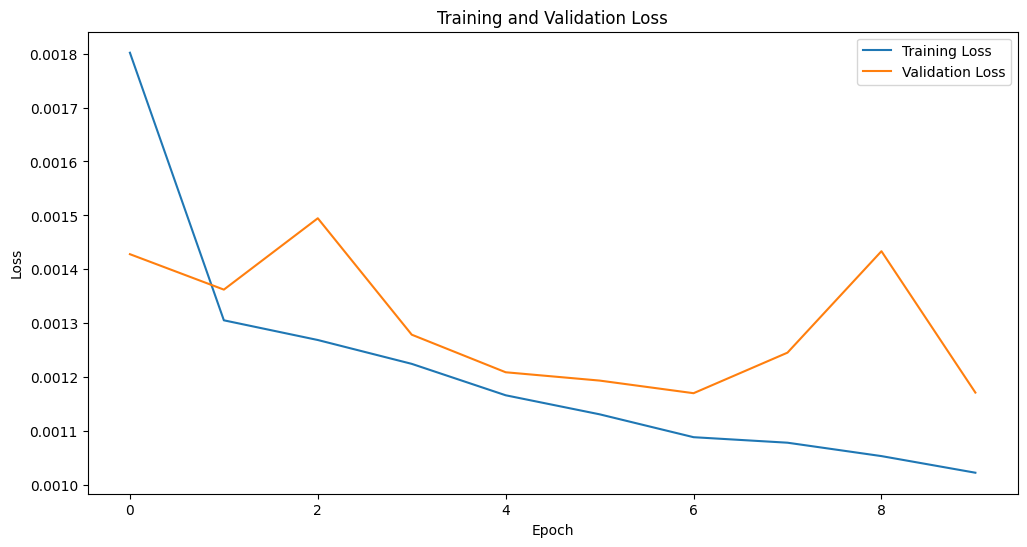

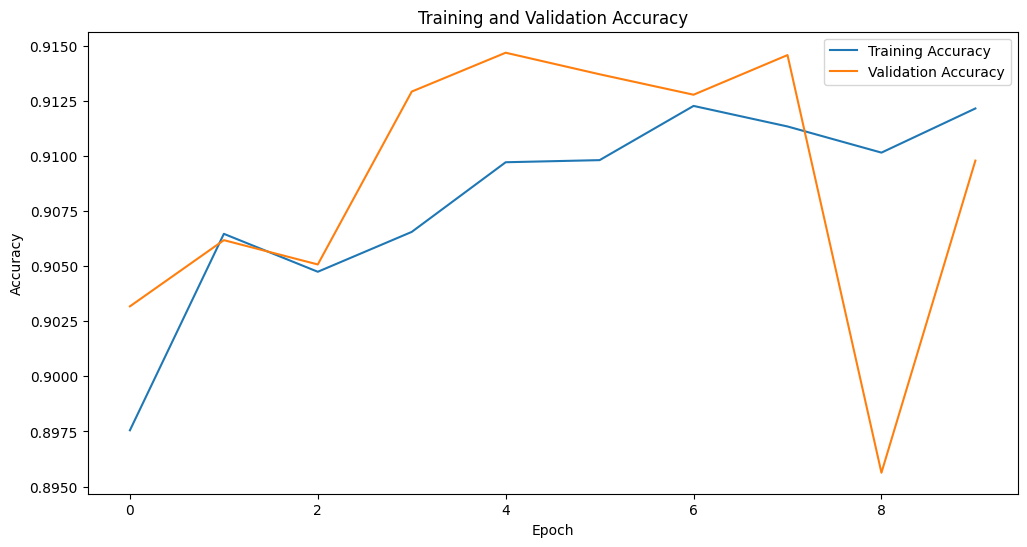

In [16]:
# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Evaluation Metrics

In [ ]:
def mae(imageA, imageB, bands):
 	# the 'Mean Squared Error' between the two images is the
 	# sum of the squared difference between the two images;
 	# NOTE: the two images must have the same dimension
 	err = np.sum(np.abs(imageA.astype("float") - imageB.astype("float")))
 	err /= float(imageA.shape[0] * imageA.shape[1] * bands)

In [ ]:
def psnr(img1, img2):
    mse = np.mean( (img1.astype("float") - img2.astype("float")) ** 2 )
    # print(mse)
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

In [ ]:
def mse(imageA, imageB, nband):
	# the 'Mean Squared Error' between the two images is the
	# sum of the squared difference between the two images;
	# NOTE: the two images must have the same dimension
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1] * nband)

	# return the MSE, the lower the error, the more "similar"
	# the two images are
	return err

In [ ]:
def rmse(imageA, imageB, nband):
	# the 'Mean Squared Error' between the two images is the
	# sum of the squared difference between the two images;
	# NOTE: the two images must have the same dimension
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1] * nband)
	err = np.sqrt(err)
	return err

In [ ]:
MSE_list = []
MAE_list = []
MSEr_list = []
MSEg_list = []
MSEb_list = []
RMSE_list = []
PSNR_list = []
SSIM_list = []
deltaE_list = []

for j1 in range(N):
    print('final2 image = ',j1)

    # ima0 = img_to_array(load_img(filesTs_list[j1][:]))
    # if(ima0.shape[0]%64>0):
    #     d00 = int(ima0.shape[0]/64)
    #     d0 = (d00+1)*64
    # else:
    #     d0=ima0.shape[0]
    # if(ima0.shape[1]%64>0):
    #     d11 = int(ima0.shape[1]/64)
    #     d1 = (d11+1)*64
    # else:
    #     d1=ima0.shape[1]

    # ima = np.zeros((d0,d1,ima0.shape[2]))
    # ima[0:ima0.shape[0],0:ima0.shape[1],:] = ima0
    # else:
                #     ima = ima0


    ima = cv2.imread(filesTs_list[j1][:])
    ima0 = ima


    sz0 = ima.shape[0]
    sz1 = ima.shape[1]
    sz2 = bands #ima.shape[2]

    sz0=ima0.shape[0]
    sz1=ima0.shape[1]
    ab=np.zeros((sz0,sz1,2))
    R1 = np.reshape(ima0[:,:,0],(sz0*sz1,1))
    G1 = np.reshape(ima0[:,:,1],(sz0*sz1,1))
    B1 = np.reshape(ima0[:,:,2],(sz0*sz1,1))
    L, A, B = RGB2LAB2(R1,G1,B1)
    A = np.reshape(A,(sz0,sz1))
    B = np.reshape(B,(sz0,sz1))
    ab[:,:,0] = A
    ab[:,:,1] = B
    ima_gray =  np.reshape(L,(1,sz0,sz1,1))

    predicted = model1.predict(ima_gray,verbose=0)

    predicted = np.reshape(predicted,(sz0*sz1,bands))
    Ar = predicted[:,0:1]
    Br = predicted[:,1:2]

    Rr, Gr, Br = LAB22RGB(L,Ar,Br)
    Rr = np.reshape(Rr,(sz0,sz1))
    Gr = np.reshape(Gr,(sz0,sz1))
    Br = np.reshape(Br,(sz0,sz1))
    predicted255=np.uint8(np.zeros((sz0,sz1,3)))
    predicted255[:,:,0] = Rr
    predicted255[:,:,1] = Gr
    predicted255[:,:,2] = Br

    cv2.imwrite(cwd +'/02_data/pred_swissimage/'+files_name1[j1][:]+'.tif',predicted255)




    MSE = mse(ima0,predicted255,3)
    MSEr = mse(ima0[:,:,0],predicted255[:,:,0],1)
    MSEg = mse(ima0[:,:,1],predicted255[:,:,1],1)
    MSEb = mse(ima0[:,:,2],predicted255[:,:,2],1)
    RMSE = rmse(ima0,predicted255,3) #
    # MAE = mae(ima0,predicted255,3)
    err = np.sum(np.abs(ima0.astype("float") - predicted255.astype("float")))
    MAE = err/float(ima0.shape[0] * predicted255.shape[1] * 3)
    # print('MAE = ',MAE)
        # PSNR = tf.image.psnr(, predicted255 , max_val=255)
    PSNR=psnr(ima0,predicted255)
    SSIM = ssim(ima0,predicted255, channel_axis=2) # PAST ssim(ima0,predicted255, multichannel=True) # deprecated

    ima0 = np.float32(ima0)
    predicted255 = np.float32(predicted255)
    ima0 *= 1./255
    predicted255 *= 1./255
    Lab1 = cv2.cvtColor(ima0, cv2.COLOR_BGR2Lab)
    Lab2 = cv2.cvtColor(predicted255, cv2.COLOR_BGR2Lab)
    L1, a1, b1 = cv2.split(Lab1)
    L2, a2, b2 = cv2.split(Lab2)
    #print(L2)

    Kl=1
    KC=1
    KH=1

    delta=skimage.color.deltaE_ciede2000(L1,L2, Kl, KC, KH)
    #print(len(delta))

    deltaE=np.mean(delta)
    # print("deltaE", m)

    # deltaE=delta_e_cie2000(ima0, predicted255, Kl=1, Kc=1, Kh=1)

    MSE_list.append(MSE)
    MSEr_list.append(MSEr)
    MSEg_list.append(MSEg)
    MSEb_list.append(MSEb)
    RMSE_list.append(RMSE)
    MAE_list.append(MAE)
    deltaE_list.append(deltaE)
        # MSE2_list.append(MSE2)
        # MAE2_list.append(MAE2)
    SSIM_list.append(SSIM)
    PSNR_list.append(PSNR)

    # id_Ac = id_Ac + 1

MSE_mean = np.mean(MSE_list)
MAE_mean = np.mean(MAE_list)
PSNR_mean = np.mean(PSNR_list)
SSIM_mean = np.mean(SSIM_list)
MSEr_mean = np.mean(MSEr_list)
MSEg_mean = np.mean(MSEg_list)
MSEb_mean = np.mean(MSEb_list)
RMSE_mean = np.mean(RMSE_list)
deltaE_mean = np.mean(deltaE_list)

# print('MSE_mean=',MSE_mean)
# print('RMSE_mean=',RMSE_mean)
print('deltaE_mean=',deltaE_mean)
print('MAE_mean=',MAE_mean)
print('PSNR_mean=',PSNR_mean)
print('SSIM_mean=',SSIM_mean)
